In [1]:
import json
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import random
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch

In [2]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
# Чтение JSON файла
with open('groundtruth.json', 'r') as f:
    data = json.load(f)

# Подготовка данных
train_list = []
test_list = []

for class_name, categories in data.items():
    for image_name in categories['query']:  # Категория "query" для тестовой выборки
        test_list.append((os.path.join('images', image_name), class_name))
    for category in ['ok', 'good']:  # Остальные категории для обучения и валидации
        for image_name in categories[category]:
            train_list.append((os.path.join('images', image_name), class_name))

In [4]:
label_encoder = LabelEncoder()
class_names = list(data.keys())
label_encoder.fit(class_names)
class_names = label_encoder.classes_ 
encoded_labels = label_encoder.transform(class_names) 
for class_name, encoded_label in zip(class_names, encoded_labels):
    print(f"Класс '{class_name}' был закодирован как {encoded_label}")

Класс 'all_souls' был закодирован как 0
Класс 'ashmolean' был закодирован как 1
Класс 'balliol' был закодирован как 2
Класс 'bodleian' был закодирован как 3
Класс 'christ_church' был закодирован как 4
Класс 'cornmarket' был закодирован как 5
Класс 'hertford' был закодирован как 6
Класс 'keble' был закодирован как 7
Класс 'magdalen' был закодирован как 8
Класс 'pitt_rivers' был закодирован как 9
Класс 'radcliffe_camera' был закодирован как 10


In [5]:
# Определение класса датасета
class CustomDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path, label = self.data_list[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        encoded_label = label_encoder.transform([label])[0]
        encoded_label = torch.tensor(encoded_label, dtype=torch.long)
        return image, encoded_label

# Трансформация изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Создание датасетов
train_dataset = CustomDataset(train_list, transform=transform)
test_dataset = CustomDataset(test_list, transform=transform)
# Создание даталоадеров
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
from torchvision.models import resnet50, ResNet50_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
fc_new = nn.Linear(in_features=2048, out_features=11, bias=True)
model.fc = fc_new

In [8]:
# Зафиксируем все слои кроме переназначенного fc
for name, param in model.named_parameters():
    if not ('fc' in name):
        param.requires_grad = False

In [9]:
loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)

In [10]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)

    return epoch_loss, epoch_acc

In [11]:
def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)

    return epoch_loss, epoch_acc

In [12]:
num_epochs = 15
model = model.to(device)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, loss_func, opt, device)
    valid_loss, valid_acc = validate(model, test_loader, loss_func, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc.item())
    valid_accuracies.append(valid_acc.item())

    print(f"Эпоха {epoch+1}/{num_epochs}")
    print(f"Обучение - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Валидация - Loss: {valid_loss:.4f}, Accuracy: {valid_acc:.4f}")


Эпоха 1/15
Обучение - Loss: 1.7950, Accuracy: 0.3768
Валидация - Loss: 2.3903, Accuracy: 0.2000
Эпоха 2/15
Обучение - Loss: 1.0852, Accuracy: 0.7342
Валидация - Loss: 1.6671, Accuracy: 0.5818
Эпоха 3/15
Обучение - Loss: 0.7660, Accuracy: 0.8891
Валидация - Loss: 1.1529, Accuracy: 0.7273
Эпоха 4/15
Обучение - Loss: 0.5328, Accuracy: 0.9155
Валидация - Loss: 0.8524, Accuracy: 0.8545
Эпоха 5/15
Обучение - Loss: 0.4212, Accuracy: 0.9437
Валидация - Loss: 0.6249, Accuracy: 0.9455
Эпоха 6/15
Обучение - Loss: 0.3487, Accuracy: 0.9577
Валидация - Loss: 0.4911, Accuracy: 1.0000
Эпоха 7/15
Обучение - Loss: 0.2646, Accuracy: 0.9842
Валидация - Loss: 0.3649, Accuracy: 0.9818
Эпоха 8/15
Обучение - Loss: 0.2306, Accuracy: 0.9806
Валидация - Loss: 0.2886, Accuracy: 1.0000
Эпоха 9/15
Обучение - Loss: 0.2155, Accuracy: 0.9842
Валидация - Loss: 0.2494, Accuracy: 1.0000
Эпоха 10/15
Обучение - Loss: 0.1532, Accuracy: 0.9947
Валидация - Loss: 0.1864, Accuracy: 1.0000
Эпоха 11/15
Обучение - Loss: 0.1453, Ac

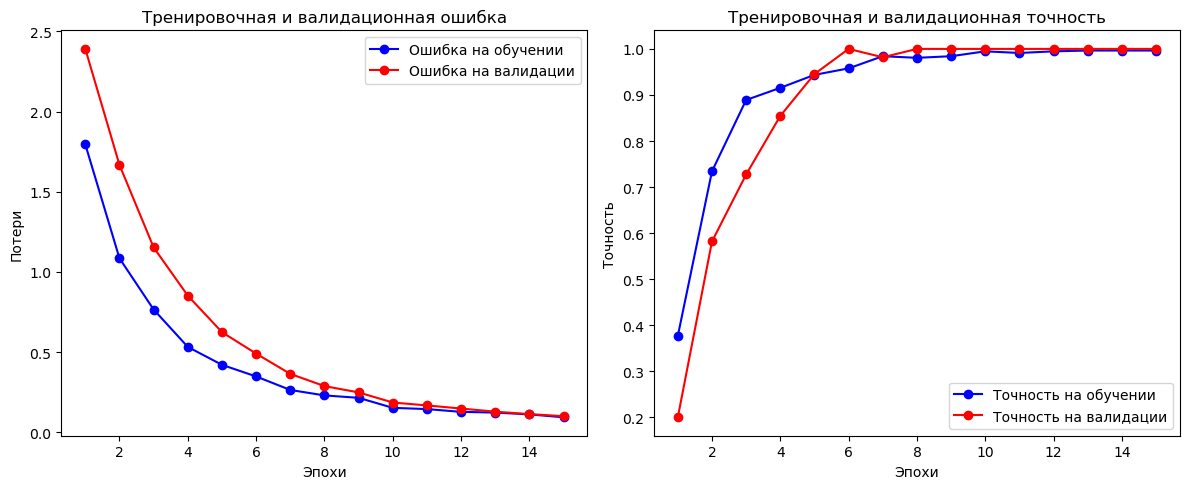

In [13]:
import matplotlib.pyplot as plt
# Количество эпох - ось X для графиков
epochs = range(1, len(train_losses) + 1)

# График потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Ошибка на обучении')
plt.plot(epochs, valid_losses, 'ro-', label='Ошибка на валидации')
plt.title('Тренировочная и валидационная ошибка')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Точность на обучении')
plt.plot(epochs, valid_accuracies, 'ro-', label='Точность на валидации')
plt.title('Тренировочная и валидационная точность')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
model.eval()
y_true_list = []
y_pred_list = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        predicted = predicted.cpu()
        y_true_list.append(label_batch.numpy())
        y_pred_list.append(predicted.numpy())
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 100.00 %


In [15]:
def get_all_predictions(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

# Получение предсказаний и меток
predictions, labels = get_all_predictions(model, test_loader, device)


In [16]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



In [17]:
import random
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def imshow(ax, img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_model(dataloader, model, num_images=10):
    model.eval()
    images, labels = [], []
    
    # Сбор изображений и меток
    for inputs, labels_batch in dataloader:
        images.extend(inputs)
        labels.extend(labels_batch)
        if len(images) >= num_images:
            break

    # Рандомный выбор изображений
    indices = random.sample(range(len(images)), num_images)
    selected_images = [images[i] for i in indices]
    selected_labels = [labels[i] for i in indices]

    # Визуализация
    fig = plt.figure(figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, num_images // 2 + num_images % 2), axes_pad=0.05)

    for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
        ax = grid[i]
        img = img.to(device)
        label = label.to(device)
        output = model(img.unsqueeze(0))
        _, pred = torch.max(output, 1)

        imshow(ax, img.cpu())
        ax.text(10, 210, f'Prediction: {pred.item()}\nReal Label: {label.item()}', 
                color='k', backgroundcolor='w', alpha=0.8)

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

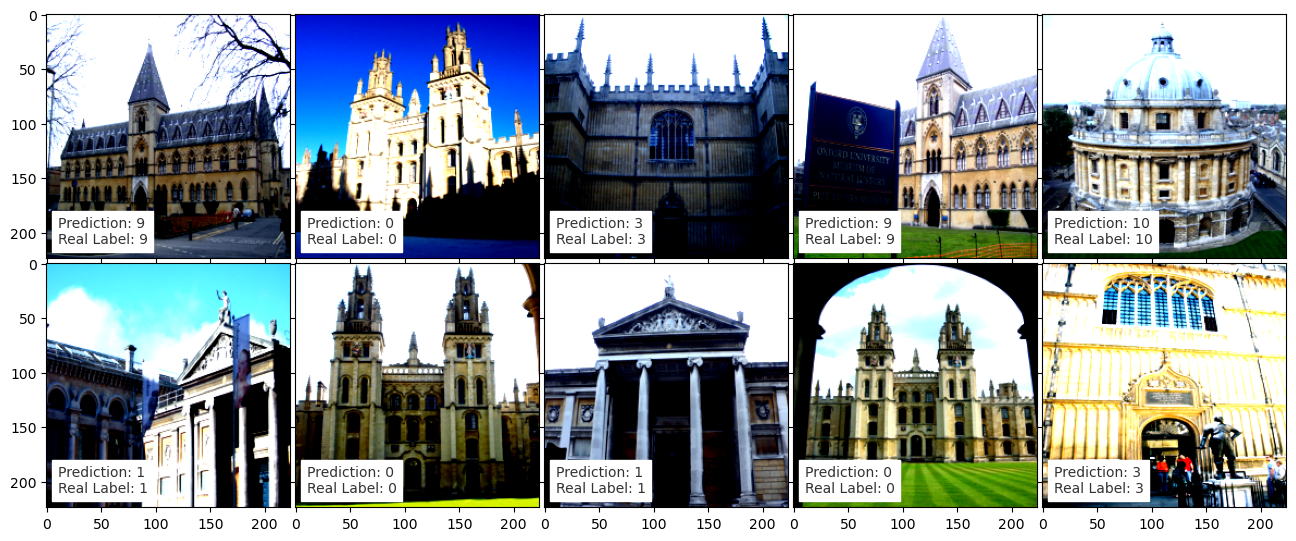

In [18]:
visualize_model(test_loader, model)

In [20]:
from torchvision.transforms.functional import to_pil_image

# Function to predict the label of a single image
def predict_image(image_path, model, transform, device):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        model.eval()
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return label_encoder.inverse_transform([predicted.item()])[0]

In [22]:
# Example usage
image_path = 'christ-church-catheral-oxford-01.jpg'
predicted_label = predict_image(image_path, model, transform, device)
print(f'Predicted label for the image: {predicted_label}')

Predicted label for the image: christ_church


In [67]:
torch.save(model.state_dict(), 'classification_resnet.pth')